# Emotion Recognition In Speech
* Zsombor Ivanyi
* University Of Milan, Italy, Milan
* 04.02.2025




Dataset links:
* RAVDESS dataset: https://zenodo.org/records/1188976
* Audio_Speech_Actors_01-24.zip: https://zenodo.org/records/1188976/files/Audio_Speech_Actors_01-24.zip?download=1
* Audio_Song_Actors_01-24.zip: https://zenodo.org/records/1188976/files/Audio_Song_Actors_01-24.zip?download=1

* TESS dataset: https://doi.org/10.5683/SP2/E8H2MF


Execute for imports:

```sh
pip install -r imports.txt

In [2]:
# Imports
import os
import time
import numpy as np
import librosa
import librosa.display
import sounddevice as sd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode

"""
import soundfile as sf
import IPython.display as ipd
from collections import Counter
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
"""

'\nimport soundfile as sf\nimport IPython.display as ipd\nfrom collections import Counter\nfrom sklearn.decomposition import PCA\nfrom imblearn.over_sampling import SMOTE\nfrom sklearn.preprocessing import OneHotEncoder\nfrom skimage.transform import resize\n'

# FEATURES
    * mfcc

In [4]:
fs = 16000 # Sampling frequency

emotion_labels = {"neutral": 1, "Calm": 2, "Happy": 3, "Sad": 4, "Angry": 5, "Fearful": 6, "Disgust": 7, "Surprised": 8}

tess_mapping = {"neutral": 1, "happy": 3, "sad":4, "angry": 5, "fear": 6, "disgust": 7} # ps not in

In [59]:
# Load saved features and labels
x = np.load("features.npy")
y = np.load("labels.npy")

print(f"Loaded {x.shape[0]} samples with {x.shape[1]} features each.")
print(f"First 10 labels: {y[:10]}")

Loaded 4852 samples with 180 features each.
First 10 labels: [6 5 3 8 3 6 5 1 2 4]


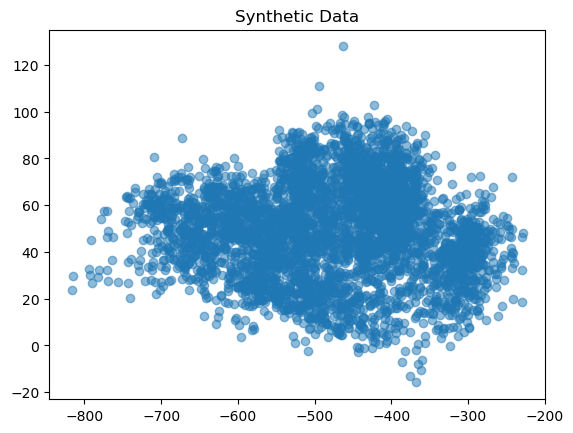

In [60]:
# x: features, y: labels
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=9)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

plt.scatter(x_train[:, 0], x_train[:, 1], alpha=0.5)
plt.title("Synthetic Data")
plt.show()

# MODELS
    * K-means
    * Random Forest
    * SVM
    * MLP

Cluster to Emotion Mapping: {0: 5, 1: 2, 2: 3, 3: 6, 4: 4, 5: 3, 6: 4, 7: 1}
K-Means Classification Accuracy: 0.32


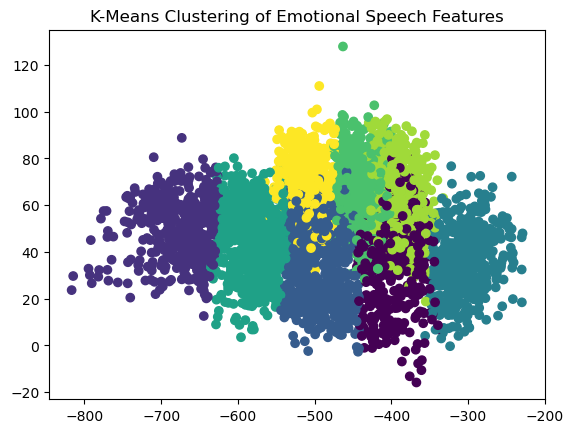

In [61]:
# Train K-Means clustering
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
labels = kmeans.fit_predict(x_train)

cluster_to_emotion = {}

for i in range(8):
    labels_in_cluster = y_train[labels == i]
    if len(labels_in_cluster) > 0:
        most_common_label = mode(labels_in_cluster, keepdims=True).mode[0]
        cluster_to_emotion[i] = most_common_label

print("Cluster to Emotion Mapping:", cluster_to_emotion)

labels_test = kmeans.predict(x_test)

# Convert cluster predictions to emotion predictions
y_pred = np.array([cluster_to_emotion[c] for c in labels_test])

kmeans_accuracy = accuracy_score(y_test, y_pred)
print(f"K-Means Classification Accuracy: {kmeans_accuracy:.2f}")


plt.scatter(x_train[:, 0], x_train[:, 1], c=labels, cmap="viridis")
plt.title("K-Means Clustering of Emotional Speech Features")
plt.show()

In [62]:
best_n = None
best_acc = 0

# Grid search for Random Forest estimator count
for n in [50, 90, 100, 150, 200, 250, 300]:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"n_estimators={n}, Accuracy={acc:.2f}")
    
    if acc > best_acc:
        best_acc = acc
        best_n = n
        print(best_n)

print(f"Best n_estimators: {best_n} with Accuracy: {best_acc:.2f}")

n_estimators=50, Accuracy=0.80
50
n_estimators=90, Accuracy=0.82
90
n_estimators=100, Accuracy=0.81
n_estimators=150, Accuracy=0.82
150
n_estimators=200, Accuracy=0.83
200
n_estimators=250, Accuracy=0.83
n_estimators=300, Accuracy=0.84
300
Best n_estimators: 300 with Accuracy: 0.84


Random Forest Accuracy: 0.84


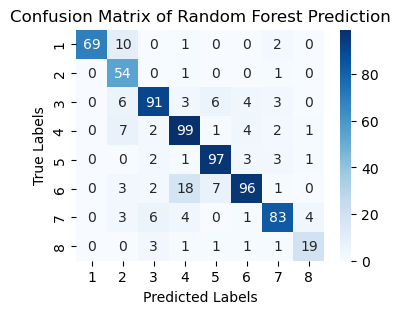

In [65]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=best_n, random_state=42)
rf.fit(x_train, y_train)

y_pred_rf = rf.predict(x_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {rf_accuracy:.2f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(1,9), yticklabels=range(1,9))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of Random Forest Prediction")
plt.show()

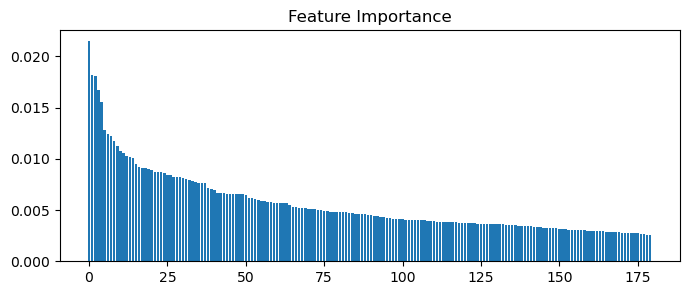

In [66]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

"""
best_n = None
best_acc = 0

# Select the top 30 features
top_n = 13
selected_features = indices[:top_n]

# Filter dataset
x_train = x_train[:, selected_features]
x_test = x_test[:, selected_features]
"""

plt.figure(figsize=(8,3))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[indices])
plt.show()

In [67]:
# Train SVM
svm = SVC(kernel='linear')
svm.fit(x_train, y_train)

y_pred = svm.predict(x_test)
svm_accuracy = accuracy_score(y_test, y_pred)

print(f"SVM Accuracy: {svm_accuracy:.2f}")


SVM Accuracy: 0.75


SVM Accuracy (With Scaling): 0.77


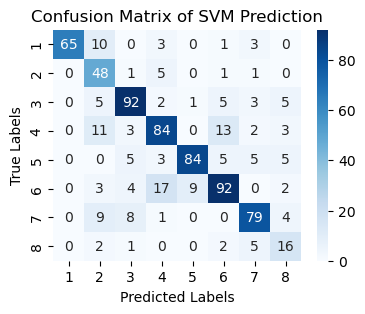

In [68]:
# Train SVM with scaled features
svm = SVC(kernel="rbf", C=1)
svm.fit(x_train_scaled, y_train)

y_pred_svm = svm.predict(x_test_scaled)
svm_scaled_accuracy = accuracy_score(y_test, y_pred_svm)

print(f"SVM Accuracy (With Scaling): {svm_scaled_accuracy:.2f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(1, 9), yticklabels=range(1, 9))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of SVM Prediction")
plt.show()

In [69]:
# Train MLP
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=500)
mlp.fit(x_train, y_train)

y_pred_mlp = mlp.predict(x_test)
mlp_accuracy = accuracy_score(y_test, y_pred_mlp)

print(f"Neural Network Accuracy: {mlp_accuracy:.2f}")

Neural Network Accuracy: 0.84


In [10]:
# Train MLP with scaled features
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=500)
mlp.fit(x_train_scaled, y_train)

y_pred_mlp = mlp.predict(x_test_scaled)
mlp_scaled_accuracy = accuracy_score(y_test, y_pred_mlp)

print(f"Neural Network Accuracy (With Scaling): {mlp_scaled_accuracy:.2f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_mlp)

fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(1, 9), yticklabels=range(1, 9))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of Neural Network Prediction")
plt.show()

NameError: name 'x_train_scaled' is not defined

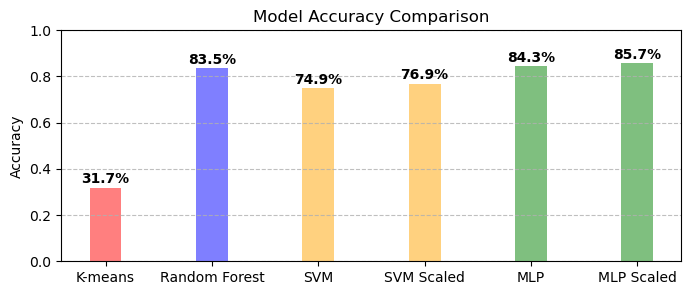

In [71]:
# Accuracy comparison
models = ["K-means", "Random Forest", "SVM", "SVM Scaled", "MLP", "MLP Scaled"]
accuracies = [kmeans_accuracy, rf_accuracy, svm_accuracy, svm_scaled_accuracy, mlp_accuracy, mlp_scaled_accuracy]

colors = ["red", "blue", "orange", "orange", "green", "green"]

fig, ax = plt.subplots(figsize=(8, 3))
bars = ax.bar(models, accuracies, color=colors, width=0.3, alpha=0.5)

ax.set_ylabel("Accuracy")
ax.set_title("Model Accuracy Comparison")
plt.ylim(0.0, 1.0)
plt.grid(axis="y", linestyle="--", alpha=0.8)

# Add percentage
for bar, accuracy in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f"{accuracy*100:.1f}%", ha='center', fontsize=10, fontweight="bold")

plt.show()

/var/folders/3h/tr62qkgx2yb0qg_tzvkhg52c0000gn/T/ipykernel_34590/3217656375.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("viridis")  # Use a color map similar to the example


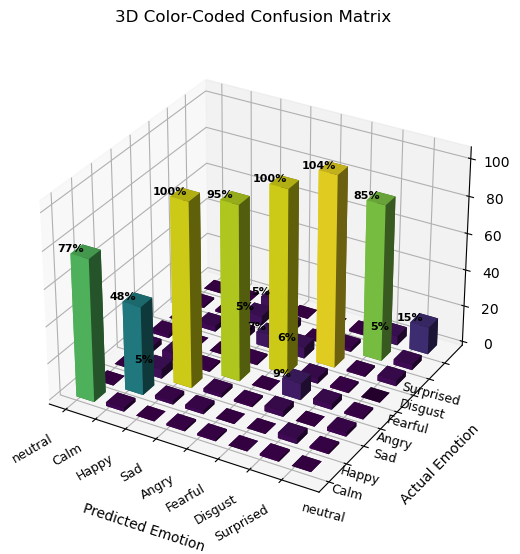

In [73]:
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

# Confusion matrix
cm_values = confusion_matrix(y_test, y_pred_mlp)
num_classes = len(emotion_labels)

# 3D bar positions
x, y = np.meshgrid(np.arange(num_classes), np.arange(num_classes))
x = x.flatten()
y = y.flatten()
z = np.zeros_like(x)

# Heights (confusion matrix values)
dx = dy = 0.6  # Bar width
dz = cm_values.flatten()

# Normalize colors based on confusion matrix values
norm = colors.Normalize(vmin=0, vmax=cm_values.max())
cmap = cm.get_cmap("viridis")  # Use a color map similar to the example
bar_colors = [cmap(norm(value)) for value in dz]

# Create 3D figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot bars with color mapping
ax.bar3d(x, y, z, dx, dy, dz, color=bar_colors, shade=True)

# Add text labels to bars (only for significant values)
for i in range(len(dz)):
    if dz[i] > cm_values.max() * 0.04:  # Only label values above 10% of max count
        ax.text(x[i], y[i], dz[i] + 1, f"{dz[i]}%", color="black", ha="center",
                fontsize=8, fontweight="bold", rotation=45)


ax.set_xlabel("Predicted Emotion", labelpad=20)
ax.set_ylabel("Actual Emotion", labelpad=10)
ax.set_zlabel("Count", labelpad=10)
ax.set_title("3D Color-Coded Confusion Matrix", pad=15)


ax.set_xticks(np.arange(num_classes))
ax.set_xticklabels(emotion_labels, rotation=30, ha="right", fontsize=9)
ax.set_yticks(np.arange(num_classes))
ax.set_yticklabels(emotion_labels, rotation=-15, ha="right", fontsize=9)


plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.2)


plt.show()

# Feature Extraction
For additional testing

In [6]:
from feature_extraction import extract

# AUDIO RECORDING
record a sentence with some emotional tone

In [7]:
length = 3  # seconds

def start_recording():
    print("Recording for 3 seconds...")

    # Record audio
    audio_data = sd.rec(int(length * fs), samplerate=fs, channels=1, dtype='float32')
    sd.wait()

    audio_data = audio_data.flatten()

    return audio_data

recorded_audio = start_recording()

Recording for 3 seconds...


In [8]:
# Play recording
sd.play(recorded_audio, samplerate=fs)
sd.wait()

In [9]:
# Predict recorded audio

# Choose a model: rf, svm, mlp
model = rf

emotion_labels = {
    1: "Neutral", 2: "Calm", 3: "Happy", 4: "Sad",
    5: "Angry", 6: "Fearful", 7: "Disgust", 8: "Surprised"
}

def classify(audio):
    # Extract features
    features = extract(audio, fs).reshape(1, -1)


    prediction = model.predict(features)[0]
    predicted_emotion = emotion_labels.get(prediction, "Unknown")

    print(f"Predicted Emotion: {predicted_emotion}")


# Manually test cases from database
#y, sr = librosa.load("example_audios/03-02-04-02-02-02-23.wav", sr=fs)
y, sr = librosa.load("example_audios/YAF_chief_disgust.wav", sr=fs)

classify(y)

NameError: name 'rf' is not defined

# AUDIO STREAMING
Continuous recording, online classification

In [770]:

length = 3    # seconds

frame = int(fs * length)  # Samples per frame


def audio_callback(indata, frames, time, status):
    if status:
        print("Error: ", status)

    audio_data = indata.flatten()

    rms = librosa.feature.rms(y=audio_data)
    if rms.mean() < 0.01:
        print("- Silence")
    else:
        # Extract features
        features = extract(audio_data, fs).reshape(1, -1)

        # Prediction
        prediction = model.predict(features)[0]
        detected_emotion = emotion_labels.get(prediction, "Unknown")

        print(f"- Emotion: {detected_emotion}")


# Start real-time classification
print("Listening for emotions...\n")
try:
    with sd.InputStream(samplerate=fs, channels=1, callback=audio_callback, blocksize=frame):
        while True:
            time.sleep(1)
except KeyboardInterrupt:
    print("\nStopped listening.")

Listening for emotions...

- Silence
- Silence
- Emotion: Fearful
- Emotion: Angry
- Emotion: Disgust
- Emotion: Disgust
- Silence
- Silence
- Emotion: Disgust
- Emotion: Sad
- Silence
- Emotion: Disgust
- Emotion: Disgust
- Emotion: Disgust
- Emotion: Disgust
- Silence
- Silence
- Silence
- Emotion: Fearful
- Silence
- Silence
- Emotion: Disgust

Stopped listening.
